In [88]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [17]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# # load the sg_object
# with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [18]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [19]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [20]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [22]:
ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/ring_anotated_cell_by_gene.csv',index_col=0)
ring_annotated_100 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_100/ring_anotated_cell_by_gene_100.csv',index_col=0)
ring_annotated_200 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_200/ring_anotated_cell_by_gene.csv',index_col=0)

In [ ]:
for ring_partition,n_partitions in zip([ring_annotated,ring_annotated_100,ring_annotated_200],[25,100,200]):


# # ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/cell_by_gene_with_rings.csv',index_col=0)
# ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/ring_anotated_cell_by_gene.csv',index_col=0)
# ring_annotated_100 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_100/ring_anotated_cell_by_gene_100.csv',index_col=0)
# ring_annotated_200 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_200/ring_anotated_cell_by_gene.csv',index_col=0)
# ring_annotated = ring_annotated_200

    adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])

    # assign erosion ring to each cell in obs according to the ring_annoted file
    adata_genes_ring.obs['erosion_ring'] = ring_partition['Erosion_Ring'].values

        # calculate the statistics for clones
    real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
    perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=100*119)
    # perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=1000)

    # calculate the scores and p-values for the clones
    scores_ring = calculate_group_scores(real_delta_ring,pd.DataFrame(perm_deltas_ring))
    p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))


    space_score_df = pd.DataFrame({'gene':scores_ring.index,'score':scores_ring,'p_val':p_vals_ring})

    space_score_df.to_csv(f'../extractedData/space_scores_{n_partitions}rings.csv',index=False)

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_4100/3311290446.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_4100/3311290446.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the 

In [11]:
ring_annotated_200.count('Erosion_Ring')

NameError: name 'ring_annotated_200' is not defined

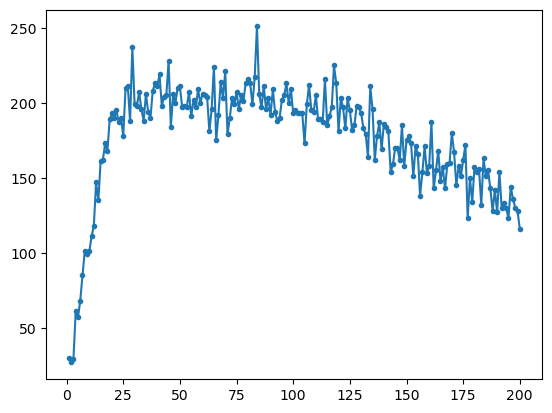

In [22]:
plt.plot(ring_annotated_200['Erosion_Ring'].value_counts().sort_index(),marker='.')

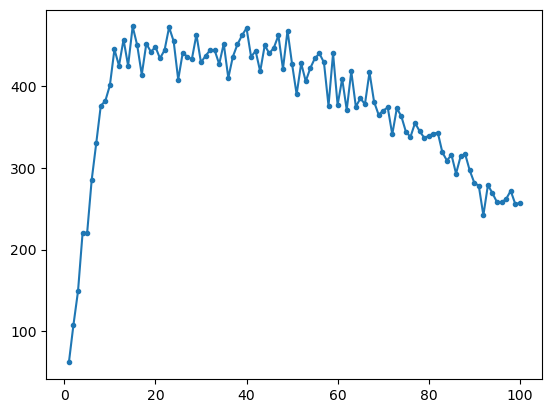

In [23]:
plt.plot(ring_annotated_100['Erosion_Ring'].value_counts().sort_index(),marker='.')

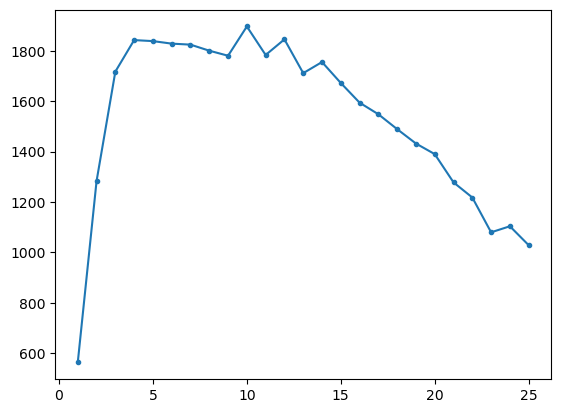

In [24]:
plt.plot(ring_annotated['Erosion_Ring'].value_counts().sort_index(),marker='.')

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

    

In [30]:
adata_genes_ring = sc.AnnData(ring_annotated_100[[col for col in ring_annotated_100.columns if col in gene_cols]])
adata_genes_ring.obs['erosion_ring'] = ring_annotated_100['Erosion_Ring'].values

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_68557/3442229808.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_annotated_100[[col for col in ring_annotated_100.columns if col in gene_cols]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


VEGFA 302.25
MITF 74.4


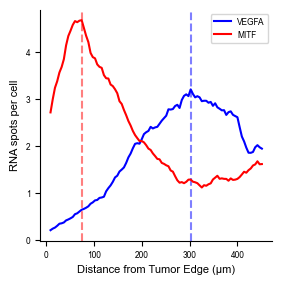

In [90]:
plt.figure(figsize=(3,3))
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')

# genes_to_show = ['VEGFA','MITF','SFRP1','SPARC']
genes_to_show = ['VEGFA','MITF']

colors = ['b','r','gray','k']
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    # plt.plot(moving_average((means_ring.loc[gene]/np.sum(means_ring.loc[gene])).values,3),label=gene,color=colors[genes_to_show.index(gene)])

    width = 4.65
    x_space = [x*width for x in range(len(means_ring.loc[gene]))]


    plt.plot(moving_average(x_space,5),moving_average((means_ring.loc[gene]).values,5),label=gene,color=colors[genes_to_show.index(gene)])

    max_idx = np.argmax(moving_average((means_ring.loc[gene]).values,5))
    plt.axvline(x=moving_average(x_space,5)[max_idx],color=colors[genes_to_show.index(gene)],linestyle='--',alpha=0.5)
    
    print(gene,moving_average(x_space,5)[max_idx])

    

plt.legend()
plt.xlabel('Distance from Tumor Edge (µm)')
plt.ylabel('RNA spots per cell')



# remove top and right spines
sns.despine()

plt.savefig('../graphs/genes_vs_distance_100rings.pdf',transparent=True,bbox_inches='tight')

In [71]:
df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,"POLYGON ((23727 1097, 23741 1098, 23776 1120, ...",POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039,NaN,NaN,NaN,NaN
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"POLYGON ((23811 1166, 23822 1166, 23829 1169, ...",POLYGON ((23807.28609323646 1156.7152330911474...,POINT (23806.27792651224 1229.8663523842781),23806.277927,1229.866352,12327.850827,NaN,NaN,NaN,NaN
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,...,"POLYGON ((19383 1449, 19398 1451, 19403 1456, ...","POLYGON ((19378.527864045 1440.055728090001, 1...",POINT (19365.23205956225 1485.2640383925368),19365.232060,1485.264038,6440.407723,NaN,NaN,NaN,NaN
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"POLYGON ((19107 1506, 19137 1507, 19157 1511, ...",POLYGON ((19091.029238372354 1530.598230956909...,POINT (19129.7205683893 1524.7188219417321),19129.720568,1524.718822,4279.403177,NaN,NaN,NaN,NaN
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"POLYGON ((15238 1549, 15252 1549, 15252 1556, ...",POLYGON ((15236.759652654107 1539.077221232863...,POINT (15196.782899770467 1575.0830145371078),15196.782900,1575.083015,5458.813969,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,67193,2.0,0.0,6.0,0.0,1.0,0.0,0.0,9.0,14.0,...,"POLYGON ((37771 46466, 37777 46470, 37785 4648...",POLYGON ((37765.537322194534 46457.62389403161...,POINT (37783.46201006832 46544.91209996404),37783.462010,46544.912100,13678.319345,NaN,NaN,NaN,NaN
67198,67199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,10.0,...,"POLYGON ((38215 46546, 38237 46547, 38260 4655...",POLYGON ((38212.44107439684 46536.332947721385...,POINT (38208.40403415784 46576.99602473498),38208.404034,46576.996025,9246.990769,NaN,NaN,NaN,NaN
67199,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,"POLYGON ((38366 46565, 38403 46566, 38439 4658...","POLYGON ((38364.1571146495 46555.171278130656,...",POINT (38384.67654884075 46598.133528126185),38384.676549,46598.133528,10661.078562,NaN,NaN,NaN,NaN
67200,67201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,"POLYGON ((38105 46579, 38137 46586, 38139 4659...","POLYGON ((38099.85504244573 46570.42507074287,...",POINT (38113.04224095191 46613.43592794579),38113.042241,46613.435928,8041.815355,NaN,NaN,NaN,NaN


In [39]:
moving_average((means_ring.loc[gene]/np.sum(means_ring.loc[gene])).values,3)

array([0.00093875, 0.00110105, 0.00131315, 0.00152821, 0.00165224,
       0.00176617, 0.00203194, 0.00212632, 0.00216208, 0.00228477,
       0.00249461, 0.00282102, 0.00277475, 0.00315968, 0.00323015,
       0.00352748, 0.00366254, 0.00361048, 0.00387301, 0.00387887,
       0.00450775, 0.00467933, 0.00473521, 0.00458708, 0.0047272 ,
       0.00505558, 0.0052902 , 0.00597852, 0.00636556, 0.00687408,
       0.00685939, 0.0073139 , 0.00781298, 0.00831454, 0.00835473,
       0.00842797, 0.00894078, 0.01012359, 0.01093995, 0.01112412,
       0.01100014, 0.01090588, 0.01100347, 0.01181047, 0.01285015,
       0.01317079, 0.01248186, 0.01237635, 0.01252517, 0.01351394,
       0.01317278, 0.01336436, 0.01365053, 0.01416597, 0.01504418,
       0.01532806, 0.01499642, 0.01491175, 0.01478686, 0.01594562,
       0.01553471, 0.01613424, 0.01660421, 0.01736861, 0.01668967,
       0.01676643, 0.01621296, 0.01636977, 0.01607387, 0.01604395,
       0.01603925, 0.01535091, 0.01571635, 0.01577805, 0.01582

In [37]:
(means_ring.loc[gene]/np.sum(means_ring.loc[gene])).values

array([0.00077496, 0.00103806, 0.00100323, 0.00126185, 0.00167438,
       0.00164841, 0.00163394, 0.00201617, 0.00244569, 0.0019171 ,
       0.00212344, 0.00281376, 0.00254664, 0.00310267, 0.00267494,
       0.00370143, 0.00331406, 0.00356694, 0.00410662, 0.00315788,
       0.00435453, 0.00412419, 0.00504453, 0.00486927, 0.00429182,
       0.00460016, 0.00528962, 0.00527696, 0.00530401, 0.00735458,
       0.00643809, 0.00682956, 0.00731052, 0.00780161, 0.0083268 ,
       0.0088152 , 0.00792219, 0.0085465 , 0.01035365, 0.01147063,
       0.01099556, 0.01090617, 0.01109867, 0.0107128 , 0.01119893,
       0.01351968, 0.01383183, 0.01216085, 0.0114529 , 0.01351529,
       0.01260732, 0.01441922, 0.0124918 , 0.01318205, 0.01527775,
       0.0140381 , 0.0158167 , 0.0161294 , 0.01304318, 0.01556266,
       0.01575475, 0.01651945, 0.01432993, 0.01755333, 0.01792938,
       0.01662311, 0.01551651, 0.01815966, 0.01496271, 0.01598695,
       0.01727195, 0.01487294, 0.01597287, 0.01520693, 0.01596

In [42]:

means_ring.loc[gene]

1       9.758065
2      10.277778
3      14.516779
4      16.031818
5      16.009091
         ...    
96      9.910853
97      8.652672
98      7.051471
99      8.632812
100     7.237354
Name: SPARC, Length: 100, dtype: float64

<AxesSubplot: xlabel='center_x', ylabel='center_y'>

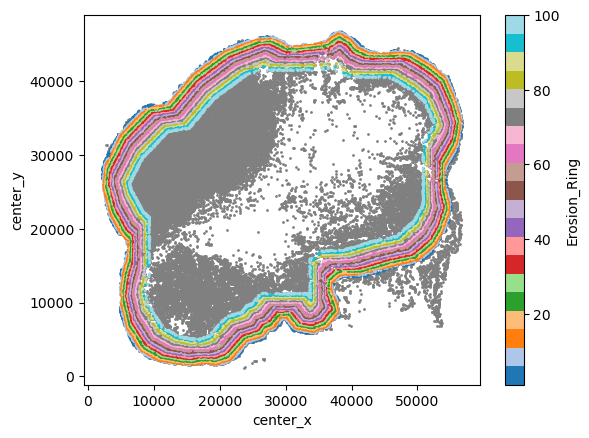

In [75]:

plt.figure()
ax = plt.gca()
df.plot.scatter(x='center_x',y='center_y',c='gray',s=1,ax=ax)


ring_annotated_100.plot.scatter(x='center_x',y='center_y',c='Erosion_Ring',cmap='tab20',s=1,ax=ax)

In [64]:
# each ring corresponds to some number of pixels from the edge of the tumor
# calculate the distance from the edge of the tumor for each pixel in the erosion ring

# to do this, we can ask how far each cell in ring X is from the closest cell in ring X-1

# calculate the distance for each cell in ring X to the closest cell in ring X-1

X = 20

scipy.stats.distance.pdist(ring_annotated_100[ring_annotated_100['Errosion_Ring'] == X]

# for each cell in ring X, find the closest cell in ring X-1
# calculate the distance between the two cells
# assign this distance to the cell in ring X






KeyError: 'radius'

In [69]:
ring_annotated_100['distance_to_center'].groupby('Erosion_Ring')

KeyError: 'Erosion_Ring'

In [68]:
ring_annotated_100

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,nucleus_centroid,center_x,center_y,area,Ring,Index,X,Y,Erosion_Ring,distance_to_center
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (22862.84997635934 2861.3139479905435),22862.849976,2861.313948,6224.823548,39,868.0,22862.0,2861.0,1,22452.852403
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (23138.498342584026 3139.5531144002466),23138.498343,3139.553114,7014.802650,36,1142.0,23138.0,3139.0,1,22115.022320
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (6814.841070681723 4431.163181374599),6814.841071,4431.163181,4563.303206,64,2418.0,6814.0,4431.0,1,29621.774953
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (25073.469807242735 4625.117242291914),25073.469807,4625.117242,6423.645896,4,2617.0,25073.0,4624.0,1,20260.083537
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,POINT (26070.082960310352 4922.037131773031),26070.082960,4922.037132,6789.503914,17,2956.0,26070.0,4922.0,1,19819.909369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (30239.862479347375 41374.170074349444),30239.862479,41374.170074,9777.358042,66,60914.0,30239.0,41374.0,100,16872.084978
37504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (28758.318368788954 41380.992076109724),28758.318369,41380.992076,9892.393238,6,60922.0,28758.0,41381.0,100,16792.617611
37505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (29598.600060083256 41386.43697695378),29598.600060,41386.436977,6466.850790,70,60944.0,29598.0,41386.0,100,16831.020818
37506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POINT (35701.786709324806 41490.22528827567),35701.786709,41490.225288,4618.761084,64,61119.0,35701.0,41490.0,100,18363.231619


In [70]:
ring_annotated_100['distance_to_center']

0        22452.852403
1        22115.022320
2        29621.774953
3        20260.083537
4        19819.909369
             ...     
37503    16872.084978
37504    16792.617611
37505    16831.020818
37506    18363.231619
37507    19164.417800
Name: distance_to_center, Length: 37508, dtype: float64